In [ ]:
import torch
import leap
from leap import LeapForCausalLM, LeapConfig
from lstm import LstmForCausalLM
from transformers import (PreTrainedTokenizerFast, TrainingArguments,
                          Trainer, default_data_collator,
                          GPT2Config, GPT2LMHeadModel)

from datasets import load_dataset, Dataset, DatasetDict, load_from_disk
from torch.utils.data import Subset

# word level tokenizer as per wikitext modeling
from tokenizers import Tokenizer
from tokenizers.models import WordLevel
from tokenizers.pre_tokenizers import Whitespace
from tokenizers.trainers import WordLevelTrainer

import math
import copy
from itertools import chain

import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import numpy as np

import logging
logging.disable(logging.INFO)

In [ ]:
# globals
param_data_ratio = 1 / 10
seq_len = 2048

# hyperparameters
training_args = TrainingArguments(
    output_dir = "./results",
    logging_strategy = "steps",
    evaluation_strategy = "steps",
    logging_steps = 1000,
    report_to = "none",
    learning_rate = 1e-3,
    lr_scheduler_type = "cosine",
    warmup_ratio = .05,
    num_train_epochs = 1,
    per_device_train_batch_size = 12,
    per_device_eval_batch_size = 12,
    max_grad_norm = 1,
    fp16 = True,
    log_level = 'error'
)

# see appendix for creating this file
lm_dataset = load_from_disk('8192_wikitext.dt')

## helper functions

In [ ]:
def subset_data(dataset, num_parameters, param_data_ratio):
    dataset = DatasetDict(copy.deepcopy(dataset))
    subset_num_tokens = num_parameters / param_data_ratio
    
    global seq_len
    num_rows = int(subset_num_tokens) // seq_len

    training_set = dataset["train"]
    dataset["train"] = Dataset.from_dict(training_set[:num_rows+1])
    
    real_num_tokens = len(dataset["train"]) * seq_len
    
    dataset.set_format('pt')
    return dataset

def run_training(hidden_size, n_head = None, gpt = False):
    # calculate number of layers needed based on levine 2020
    n_layer = round((math.log(hidden_size) - 5.039) / 5.55e-2)
    n_layer = max(1, n_layer)
    
    if gpt is True:
        config = GPT2Config(
            n_embd = hidden_size, n_layer = n_layer, n_head = n_head,
            vocab_size = 8192, n_positions = seq_len,
            initializer_range = 1 / hidden_size**.5,
            resid_pdrop = 0, embd_pdrop = 0, attn_pdrop = 0 # no dropout bc one epoch
        )
        model = GPT2LMHeadModel(config)
    else:
        config = LeapConfig(
            hidden_size = hidden_size, n_layer = n_layer, n_head = n_head,
            vocab_size = 8192, n_positions = seq_len,
            use_local_att = True, window_sizes = None, rescale = 10,
            initializer_range = 1 / hidden_size**.5, hidden_dropout_prob = 0 # no dropout bc one epoch
        )
        model = LeapForCausalLM(config)

    # get number of parameters
    total_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)
    
    # get rid of embedding parameters
    token_embeddings = 8192 * hidden_size
    position_embeddings = seq_len * hidden_size
    non_embedding_parameters = total_parameters - token_embeddings - position_embeddings

    # subset dataset using global lm_dataset
    global lm_dataset
    subset_datasets = subset_data(lm_dataset, non_embedding_parameters, param_data_ratio)

    trainer = Trainer(
        model=model,
        args=training_args,
        data_collator=default_data_collator,
        train_dataset=subset_datasets["train"],
        eval_dataset=subset_datasets["validation"],
    )

    trainer.train()
    
    best_valid_loss = trainer.evaluate()["eval_loss"]

    # save gpu memory
    del trainer
    del model
    del subset_datasets
    torch.cuda.empty_cache()
    
    return non_embedding_parameters, best_valid_loss

# TRAINING FUNCTION

In [ ]:
sizes = [
    {"hidden_size": 64, "n_head": 1},
    {"hidden_size": 128, "n_head": 2},
    {"hidden_size": 160, "n_head": 2},
    {"hidden_size": 176, "n_head": 2},
    {"hidden_size": 192, "n_head": 3},
    {"hidden_size": 224, "n_head": 4},
    {"hidden_size": 256, "n_head": 4},
]

def powerlaw(n, n_c, a):
    return (n_c / n)**a

def try_scaling(gpt = False):
    params = []
    losses = []

    for size in sizes:
        param, loss = run_training(**size, gpt = gpt)
        params.append(param)
        losses.append(loss)
    
    # graphing and powerlaws 
    params = np.array(params, dtype = 'int64')
    losses = np.array(losses, dtype = 'float64')
    
    plt.loglog()
    plt.scatter(x = params, y = losses)
    (n_c, a), _ = curve_fit(powerlaw, params, losses, maxfev=10000, p0 = np.array([9e13, .076]))
    plt.plot(params, powerlaw(params, n_c, a), linestyle = '--')
    plt.show()
    
    print("\n===============RAW NUMBERS===============\n")
    print("Parameters:", list(params))
    print("Losses:", list(losses))
    
    print("\n===============SCALING LAW===============\n")
    print(f"Constant factor N_c: {n_c:.0}, Exponent: {a:.3}")

# Ablations

The idea here is instead of changing the source code in LEAP.py over and over again and then running personal experiments, that it makes much more sense to record this stuff in a notebook. Still it seems like a bad option to have to write a bunch of if statements about which little abalation to use. The solution, monkey patching! We will rewrite the LEAP forward function before each abalation test. An example is shown, and this notebook will be annotated

## original forward function

In [ ]:
def forward(self, q, f, k, v, attention_mask = None):        
        batch_size, seq_len, hidden_size = v.shape
        
        # reshape for multihead formulation
        q = q.reshape(batch_size, seq_len, self.n_head, self.head_size)
        f = f.reshape(batch_size, seq_len, self.n_head, self.head_size)
        k = k.reshape(batch_size, seq_len, self.n_head, self.head_size)
        v = v.reshape(batch_size, seq_len, self.n_head, self.head_size)
        
        # unparameterized norming of vectors so dot products don't explode (also why it is after reshaping)
        if self.rescale:
            q = self.__real_norm(q)
            f = self.__real_norm(f)
            k = self.__real_norm(k)
            v = self.__real_norm(v)
            
        # dropout regularization (keys don't need dropout as they are always dotted with a dropped out vector)
        q = self.drop(q)
        f = self.drop(f)
        v = self.drop(v)

        # manual "matrix dot product" for speed (in einsum notation "bshe, bshe->bsh") with scaling
        focus_logits = (f * k).sum(dim = -1) * self.scaling_factor
        
        # apply dropout to logits so that all tokens will have a chance at getting focus
        focus_logits = self.drop(focus_logits)
        
        # masking out pad tokens
        if attention_mask is not None:
            focus_logits += attention_mask
        
        # manual softmax within cumulative sum
        focus_weights = torch.exp(focus_logits)
        focus_weights = focus_weights.unsqueeze(-1)
        
        # normalization term for softmax
        cumulative_weights = torch.cumsum(focus_weights, dim = 1)
        cumulative_weights = cumulative_weights - self.__window_align(cumulative_weights)
        
        focused_k = self.__w_focus(focus_weights, cumulative_weights, k)
        focused_v = self.__w_focus(focus_weights, cumulative_weights, v)
        
        # querying by measuring dot product alignment (with scaling)
        alignment = torch.sigmoid((q * focused_k).sum(dim = -1) * self.scaling_factor)
        attention = alignment.unsqueeze(-1) * focused_v
        
        # concat heads
        attention = focused_v.reshape(batch_size, seq_len, hidden_size)
        
        return attention

C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss


Step,Training Loss,Validation Loss


Step,Training Loss,Validation Loss


Step,Training Loss,Validation Loss


Step,Training Loss,Validation Loss


C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss
1000,4.861500,4.326162


C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss
1000,4.835300,4.250451
2000,4.061200,3.938624


<ipython-input-29-795d6ed49ad2>:12: RuntimeWarning: invalid value encountered in power
  return (n_c / n)**a


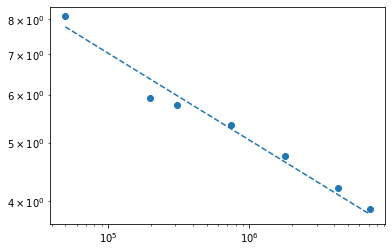


===============RAW NUMBERS===============

Parameters: [49856, 198016, 308960, 746944, 1776768, 4229344, 7099136]
Losses: [8.088715553283691, 5.93641996383667, 5.764010429382324, 5.351748943328857, 4.7581892013549805, 4.203468322753906, 3.8781819343566895]

===============SCALING LAW===============

Constant factor N_c: 8e+10, Exponent: 0.144


In [ ]:
try_scaling()

## monkey patched

In [ ]:
def forward(self, q, f, k, v, attention_mask = None):        
    print("we abalate the entirety of LEAP here :)", end = '\r')
    return v

leap.MultiheadLeap.forward = forward

C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss


Step,Training Loss,Validation Loss


Step,Training Loss,Validation Loss


Step,Training Loss,Validation Loss


Step,Training Loss,Validation Loss


C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss
1000,5.141800,4.884054


C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss
1000,5.146100,4.880362
2000,4.795100,4.791285


<ipython-input-29-795d6ed49ad2>:12: RuntimeWarning: invalid value encountered in power
  return (n_c / n)**a


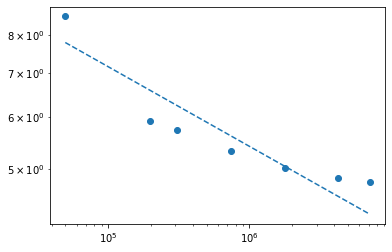


===============RAW NUMBERS===============

Parameters: [49856, 198016, 308960, 746944, 1776768, 4229344, 7099136]
Losses: [8.534381866455078, 5.9223833084106445, 5.720045566558838, 5.328155994415283, 5.014240741729736, 4.841979026794434, 4.766572952270508]

===============SCALING LAW===============

Constant factor N_c: 1e+12, Exponent: 0.121


In [ ]:
try_scaling()

# Appendix

In [ ]:
raw_datasets = load_dataset("wikitext", "wikitext-103-v1")

# make a word level tokenizer
tokenizer = Tokenizer(WordLevel(unk_token="<unk>"))
tokenizer.pre_tokenizer = Whitespace()
tokenizer.enable_padding(pad_id = 0, pad_token = "<pad>")
# no post processing

# only use vocab size of 8192 for reasonable speed/memory
token_trainer = WordLevelTrainer(vocab_size = 8191, # -1 for pad token
                                 special_tokens = ["<unk>"])

def batch_iterator(batch_size=10000):
    text = raw_datasets["train"]['text']
    for i in range(0, len(text), batch_size):
        yield text[i : i + batch_size]

tokenizer.train_from_iterator(batch_iterator(),
                              trainer = token_trainer,
                              length = len(raw_datasets["train"]["text"]))
tokenizer = PreTrainedTokenizerFast(tokenizer_object = tokenizer, pad_token = "<pad>")

# tokenized the dataset
def tokenize_function(examples):
    output = tokenizer(examples["text"])
    return output

# tokenize dataset
tokenized_datasets = raw_datasets.map(
    tokenize_function,
    batched = True,
    remove_columns = "text",
    desc = f"tokenize dataset",
    load_from_cache_file = True
)

def group_texts(examples):
    # Concatenate all texts
    concatenated_examples = {k: list(chain(*examples[k])) for k in examples.keys()}
    total_length = len(concatenated_examples[list(examples.keys())[0]])

    # Split by chunks of max_len
    result = {
        k: [t[i : i + seq_len] for i in range(0, total_length, seq_len)]
        for k, t in concatenated_examples.items()
    }
    
    # for language modeling, inputs are labels (they will be shifted inside the model)
    result["labels"] = result["input_ids"].copy()
    
    # pad last block with 0
    last_ids = result["input_ids"][-1]
    diff = seq_len - len(last_ids)
    result["input_ids"][-1] = last_ids + [0 for _ in range(diff)]
    
    # set attention mask to mask out these tokens
    result["attention_mask"][-1] = result["attention_mask"][-1] + [0 for _ in range(diff)]
    
    # set pad labels to -100 so they will be ignored by CrossEntropyLoss
    result["labels"][-1] = result["labels"][-1] + [-100 for _ in range(diff)]
    return result

lm_dataset = tokenized_datasets.map(
    group_texts,
    batched = True,
    batch_size = 10000,
    desc = f"Grouping texts in chunks of {seq_len}",
    load_from_cache_file = True
)

lm_dataset = lm_dataset.remove_columns(["token_type_ids"])

Found cached dataset wikitext (C:/Users/micha/.cache/huggingface/datasets/wikitext/wikitext-103-v1/1.0.0/a241db52902eaf2c6aa732210bead40c090019a499ceb13bcbfa3f8ab646a126)


  0%|          | 0/3 [00:00<?, ?it/s]

Loading cached processed dataset at C:/Users/micha/.cache/huggingface/datasets/wikitext/wikitext-103-v1/1.0.0/a241db52902eaf2c6aa732210bead40c090019a499ceb13bcbfa3f8ab646a126\cache-a2031eb206d20f87.arrow
Loading cached processed dataset at C:/Users/micha/.cache/huggingface/datasets/wikitext/wikitext-103-v1/1.0.0/a241db52902eaf2c6aa732210bead40c090019a499ceb13bcbfa3f8ab646a126\cache-8f3dd2e5d5819fe2.arrow
Loading cached processed dataset at C:/Users/micha/.cache/huggingface/datasets/wikitext/wikitext-103-v1/1.0.0/a241db52902eaf2c6aa732210bead40c090019a499ceb13bcbfa3f8ab646a126\cache-f4668efef485cbea.arrow
Loading cached processed dataset at C:/Users/micha/.cache/huggingface/datasets/wikitext/wikitext-103-v1/1.0.0/a241db52902eaf2c6aa732210bead40c090019a499ceb13bcbfa3f8ab646a126\cache-c465af52033c5930.arrow
Loading cached processed dataset at C:/Users/micha/.cache/huggingface/datasets/wikitext/wikitext-103-v1/1.0.0/a241db52902eaf2c6aa732210bead40c090019a499ceb13bcbfa3f8ab646a126\cache-f4b

In [ ]:
len(tokenizer) + 1

8192